Downloading...
From: https://drive.google.com/uc?id=16OrdGcOBIL5eockutkfeDvqGT8384J3y&confirm=t
To: /content/dataset.zip
100% 166M/166M [00:04<00:00, 35.5MB/s]


In [2]:
!unzip -q '/content/dataset.zip'

dataset/with_mask/0_0_œ¬‘ÿ.png:  mismatching "local" filename (dataset/with_mask/0_0_┼У┬мтАШ├┐.png),
         continuing with "central" filename version
dataset/with_mask/0_0_≈˙◊¢ 2020-02-23 132115.png:  mismatching "local" filename (dataset/with_mask/0_0_тЙИ╦ЩтЧК┬в 2020-02-23 132115.png),
         continuing with "central" filename version
dataset/with_mask/0_0_≈˙◊¢ 2020-02-23 132400.png:  mismatching "local" filename (dataset/with_mask/0_0_тЙИ╦ЩтЧК┬в 2020-02-23 132400.png),
         continuing with "central" filename version
dataset/with_mask/0_0_≈˙◊¢ 2020-02-24 171804.png:  mismatching "local" filename (dataset/with_mask/0_0_тЙИ╦ЩтЧК┬в 2020-02-24 171804.png),
         continuing with "central" filename version
dataset/with_mask/0_0_≈˙◊¢ 2020-02-24 172039.png:  mismatching "local" filename (dataset/with_mask/0_0_тЙИ╦ЩтЧК┬в 2020-02-24 172039.png),
         continuing with "central" filename version
dataset/with_mask/0_0_≈˙◊¢ 2020-02-24 202509.png:  mismatching "local" filename (datase

In [3]:
# Requirements
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from tensorflow.keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# Set the paths to the folders containing the images
with_mask_folder = '/content/dataset/with_mask'
without_mask_folder = '/content/dataset/without_mask'

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (150,150))
            if img is not None:
                images.append(img)
    return images

# Load images with masks
with_mask_images = load_images_from_folder(with_mask_folder)

# Load images without masks
without_mask_images = load_images_from_folder(without_mask_folder)

# Create labels for the images
with_mask_labels = np.ones(len(with_mask_images))  # Masked faces are labeled as 1
without_mask_labels = np.zeros(len(without_mask_images))  # Unmasked faces are labeled as 0

# Combine the images and labels
X_train = np.array(with_mask_images + without_mask_images)
y_train = np.concatenate((with_mask_labels, without_mask_labels))

# Shuffle the data
# shuffle_indices = np.random.permutation(len(X_train))
# X_train = X_train[shuffle_indices]
# y_train = y_train[shuffle_indices]

In [5]:
mean = np.mean(X_train, axis=(0,1,2))
std = np.std(X_train, axis=(0,1,2))

# Z-score normalize the images
train_images = (X_train - mean) / std

In [6]:
# Generate Image
concatenated_train_images = []
concatenated_train_labels = []

datagen = ImageDataGenerator(rotation_range=15,
                             zoom_range=0.1,
                             brightness_range=(0.9,1.1))
aug = datagen.flow(train_images, y_train, batch_size=train_images.shape[0])
# concatenated_train_images = np.concatenate((train_images, aug[0][0]), axis=0)
# concatenated_train_labels = np.concatenate((y_train, aug[0][1]), axis=0)
concatenated_train_images = aug[0][0]
concatenated_train_labels = aug[0][1]

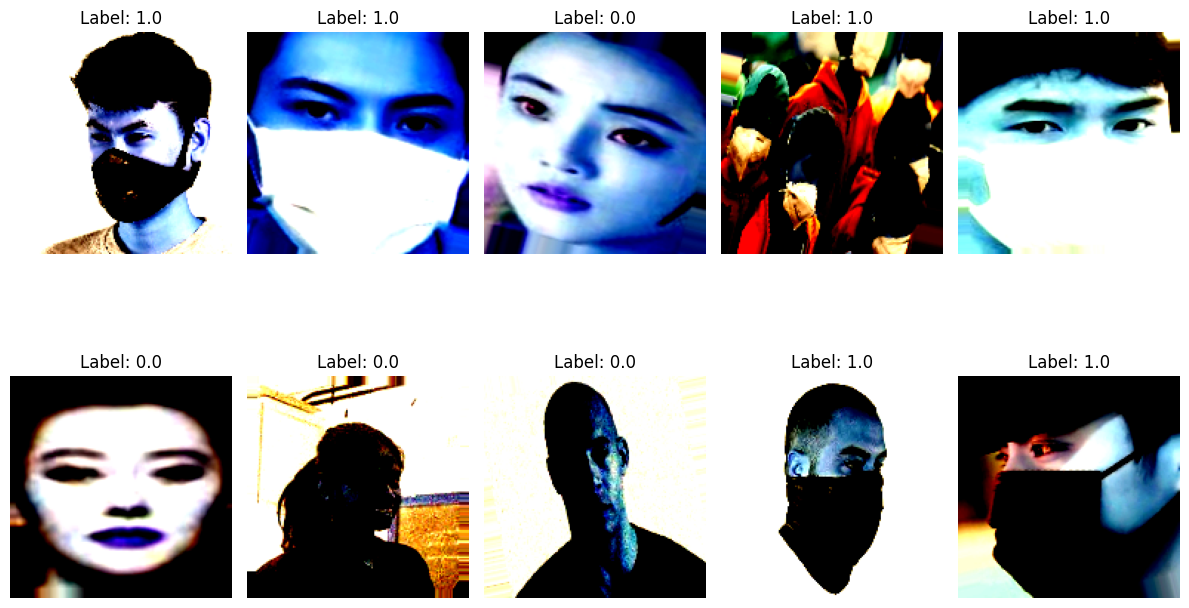

In [7]:
# Function to display images with labels
def display_images(images, labels):
    plt.figure(figsize=(12, 8))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        random = np.random.randint(0, len(images))
        plt.imshow(images[random], cmap='gray')
        plt.title('Label: ' + str(labels[random]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 images from the augmented dataset
display_images(concatenated_train_images, concatenated_train_labels)

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(concatenated_train_images, concatenated_train_labels, test_size=0.2, random_state=42)

In [9]:
# Load the InceptionV3 model without the top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

# Add a custom head on top of the base model
model = models.Sequential()

# Add the InceptionV3 base model
model.add(base_model)

# Add the custom layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



87910968/87910968 [==============================] - 0s 0us/step


In [10]:
# Define the early stopping callback
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/5
103/103 [==============================] - 24s 96ms/step - loss: 1.1596 - accuracy: 0.9115 - val_loss: 0.1349 - val_accuracy: 0.9524
Epoch 2/5
103/103 [==============================] - 4s 42ms/step - loss: 0.1141 - accuracy: 0.9640 - val_loss: 0.1409 - val_accuracy: 0.9438
Epoch 3/5
103/103 [==============================] - 5s 48ms/step - loss: 0.1061 - accuracy: 0.9631 - val_loss: 0.1182 - val_accuracy: 0.9560
Epoch 4/5
103/103 [==============================] - 5s 46ms/step - loss: 0.0836 - accuracy: 0.9704 - val_loss: 0.1179 - val_accuracy: 0.9646
Epoch 5/5
103/103 [==============================] - 5s 48ms/step - loss: 0.0652 - accuracy: 0.9737 - val_loss: 0.0955 - val_accuracy: 0.9695


In [ ]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_loss, test_acc)

26/26 [==============================] - 39s 1s/step - loss: 0.0988 - accuracy: 0.9719
0.09884867072105408 0.9719169735908508


In [ ]:
# Plot both accuracy and loss curves
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Plot the accuracy curve
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(["accuracy", "val_accuracy"])
ax[0].set_title("Model Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

# Plot the loss curve
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(["loss", "val_loss"])
ax[1].set_title("Model Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

plt.show()

1/1 [==============================] - 0s 28ms/step


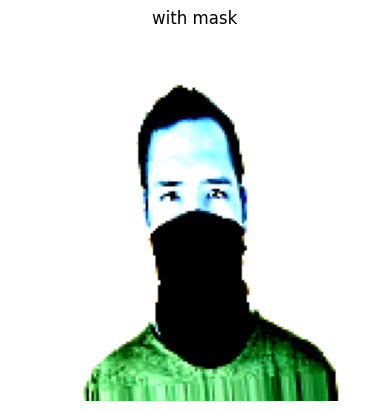

In [15]:
# Select an image index from y_train
image_index = np.random.randint(0, len(y_train))

# Retrieve the corresponding image from X_train
image = X_train[image_index]

# Preprocess the image
resized_image = cv2.resize(image, (150, 150))
preprocessed_image = resized_image / 255.0

# Reshape the image to match the model's input shape
input_image = np.expand_dims(preprocessed_image, axis=0)

# Use the trained model to predict the class label
prediction = model.predict(input_image)

# Print the predicted class label
predicted_label = "with mask" if prediction[0] > 0.5 else "without mask"
plt.imshow(image)
plt.title(predicted_label)
plt.axis('off')
plt.show()

In [16]:
model.save('my_InceptionV3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
